
# 🏡 California House Price Prediction

This notebook builds a **machine learning pipeline** to predict house prices using the California Housing dataset.  
We will go step by step through:

1. Exploratory Data Analysis (EDA)  
2. Outlier Handling  
3. Preprocessing (Scaling & PCA)  
4. Modeling with multiple algorithms  
5. Hyperparameter tuning using GridSearchCV  
6. Model evaluation with metrics and plots  


## 📦 Import Libraries & Load Data

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# Try optional models
try:
    from xgboost import XGBRegressor
    has_xgb = True
except ImportError:
    has_xgb = False

try:
    from lightgbm import LGBMRegressor
    has_lgbm = True
except ImportError:
    has_lgbm = False

# Load California Housing dataset from sklearn
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

print(X.shape, y.shape)
X.head()


(20640, 8) (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## 🔎 Exploratory Data Analysis (EDA)

In [5]:
# Missing values check
print(X.isnull().sum())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [6]:
# Summary statistics
display(X.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


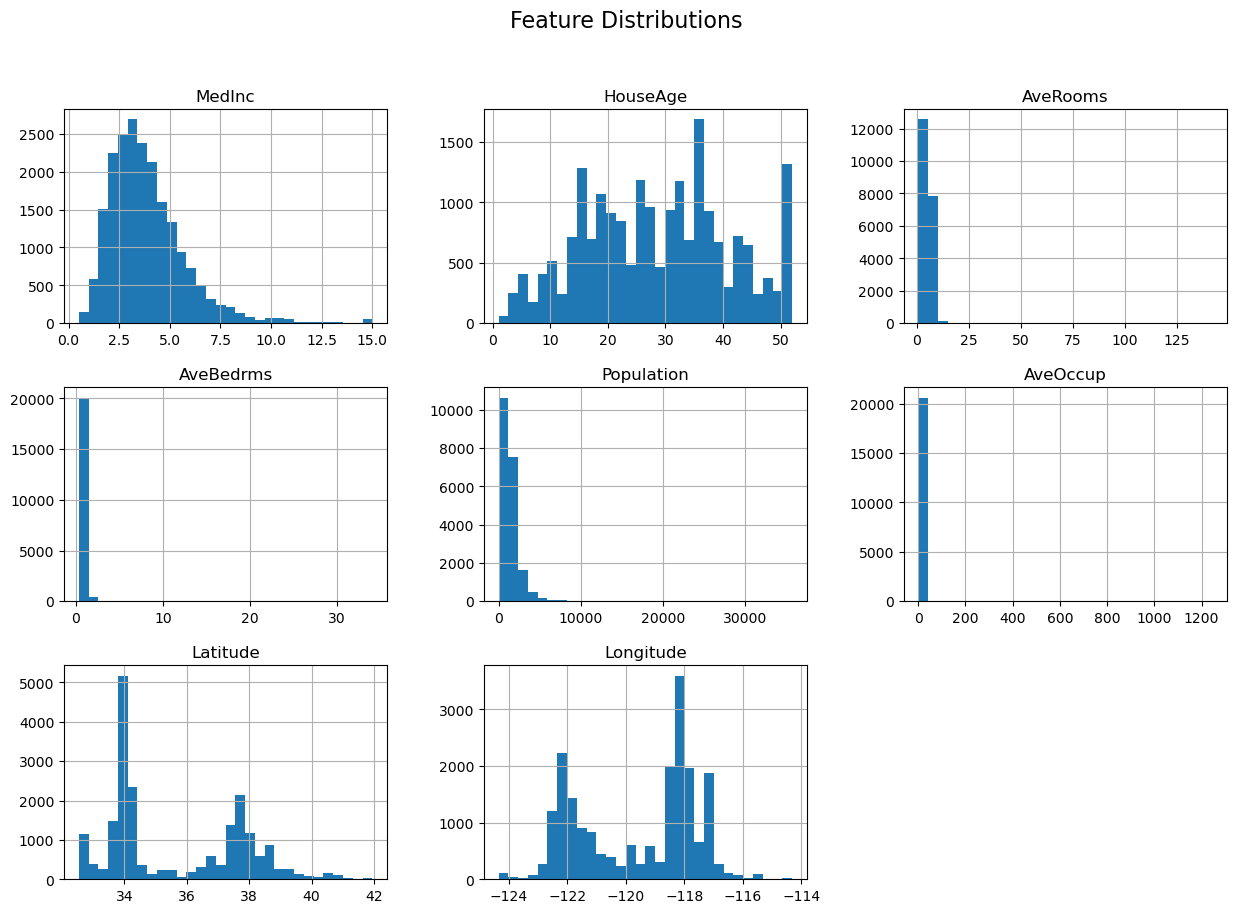

In [7]:
# Histograms
X.hist(bins=30, figsize=(15,10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

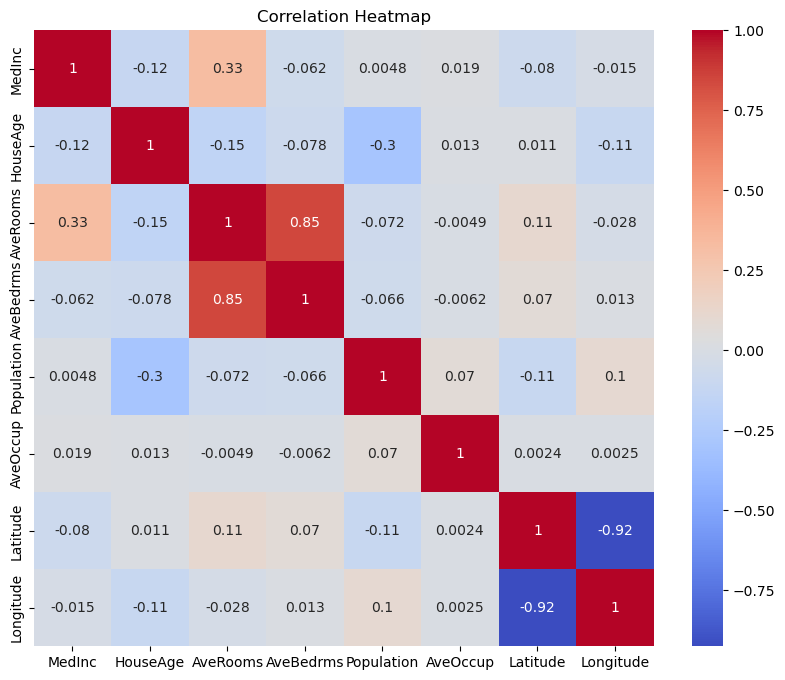

In [8]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", )
plt.title("Correlation Heatmap")
plt.show()

## ✂️ Outlier Handling

In [10]:

def cap_outliers(df, cols):
    df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)
    return df

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X_capped = cap_outliers(X, numeric_cols)


## 🎯 Target Transformation (Log Scale)

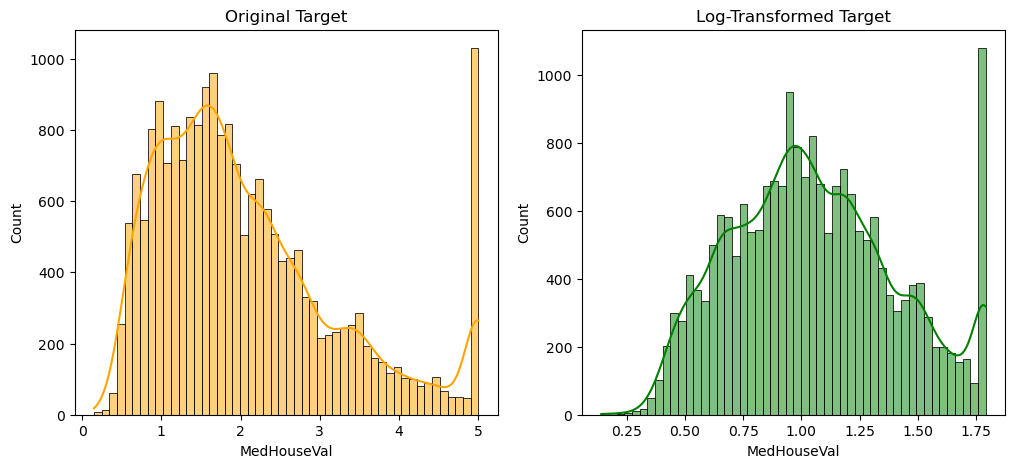

In [12]:

y_log = np.log1p(y)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(y, bins=50, kde=True, color="orange")
plt.title("Original Target")

plt.subplot(1,2,2)
sns.histplot(y_log, bins=50, kde=True, color="green")
plt.title("Log-Transformed Target")
plt.show()


## 🔀 Train-Test Split

In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    X_capped, y_log, test_size=0.2, random_state=42
)


## 🤖 Modeling & Hyperparameter Tuning

In [16]:

models = {
    "RandomForest": (RandomForestRegressor(random_state=42), {
        "model__n_estimators": [100, 200],
        "model__max_depth": [10, 20, None]
    }),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42), {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1]
    }),
    "HistGBR": (HistGradientBoostingRegressor(random_state=42), {
        "model__max_iter": [100, 200],
        "model__learning_rate": [0.05, 0.1]
    })
}

if has_xgb:
    models["XGBoost"] = (XGBRegressor(random_state=42, verbosity=0), {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1]
    })

if has_lgbm:
    models["LightGBM"] = (LGBMRegressor(random_state=42), {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1]
    })

results = {}
best_models = {}

for name, (estimator, params) in models.items():
    pipe = Pipeline([
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=0.95, random_state=42)),
        ("model", estimator)
    ])
    grid = GridSearchCV(pipe, params, cv=3, scoring="r2", n_jobs=-1)
    grid.fit(X_train, y_train)
    results[name] = grid.best_score_
    best_models[name] = grid.best_estimator_
    print(f"{name}: Best CV R² = {grid.best_score_:.4f}")


RandomForest: Best CV R² = 0.6156
GradientBoosting: Best CV R² = 0.5869
HistGBR: Best CV R² = 0.6153


## 📊 Model Evaluation

Best Model: RandomForest


C:\Users\Adham\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.5062
RMSE: 0.7051
R²: 0.6206


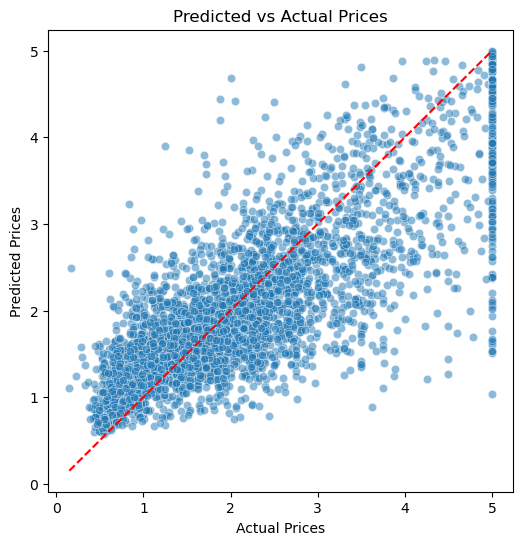

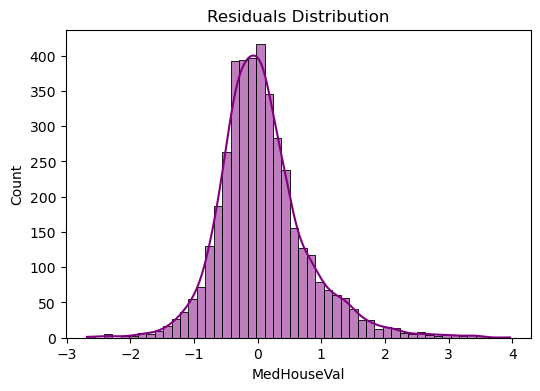

In [18]:

best_model_name = max(results, key=results.get)
best_model = best_models[best_model_name]
print("Best Model:", best_model_name)

# Predict and inverse transform
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Scatter plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
plt.show()

# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.title("Residuals Distribution")
plt.show()


## 📉 Confusion Matrix (Binned Classes)

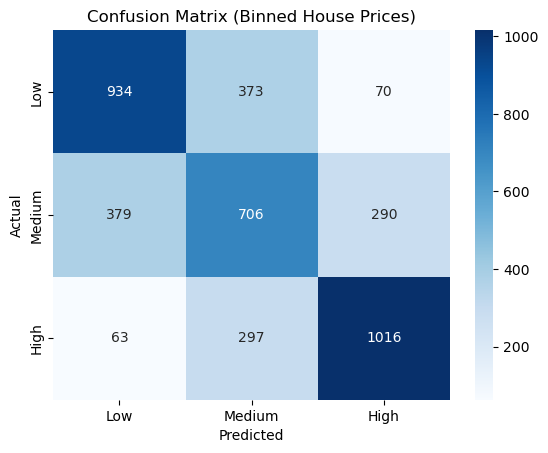

In [20]:

# Bin target into low/medium/high (quantiles)
y_bins = pd.qcut(y_true, q=3, labels=["Low","Medium","High"])
y_pred_bins = pd.qcut(y_pred, q=3, labels=["Low","Medium","High"])

cm = confusion_matrix(y_bins, y_pred_bins, labels=["Low","Medium","High"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Binned House Prices)")
plt.show()



# ✅ Conclusion

We successfully:
- Explored the dataset and visualized distributions  
- Handled outliers with IQR capping  
- Applied a log-transform to the target  
- Scaled features with RobustScaler and applied PCA  
- Trained multiple models (RandomForest, GradientBoosting, HistGBR, XGBoost, LightGBM)  
- Tuned hyperparameters using GridSearchCV  
- Selected the best model and evaluated with metrics and plots  

Next steps could include:
- Adding more feature engineering (e.g., population per household)  
- Trying advanced boosting models with larger hyperparameter grids  
- Using SHAP values for model interpretability  
